In [22]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import *
import pyspark.sql.types as t
import pyspark.sql.functions as f

In [23]:
spark = SparkSession.builder \
    .appName("logsApp") \
    .config('spark.dirver.maxResultSize', '4096') \
    .master("local[5]") \
    .getOrCreate()

In [24]:
# reload data from parquet files
df = spark.read.parquet("./output/logs_parquet/")
df.createOrReplaceTempView("logsView")

### Most requested file types

<Axes: xlabel='top_file_extensions'>

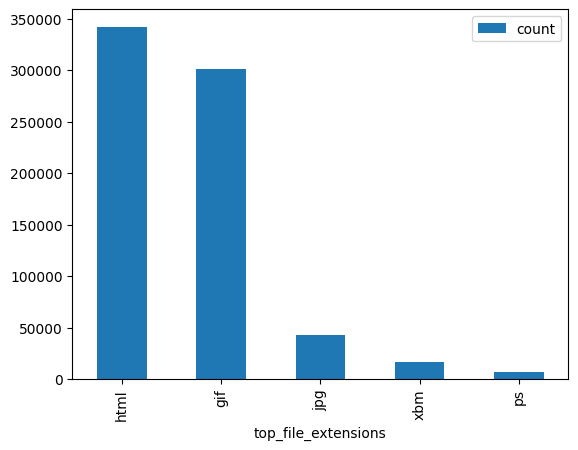

In [25]:
result = spark.sql("SELECT file_extension AS top_file_extensions, count(1) AS count "
                   "FROM logsView "
                   "GROUP BY file_extension "
                   "ORDER BY count DESC LIMIT 5").toPandas()
result.plot(x="top_file_extensions", y="count", kind="bar")

### Reply size stats

In [26]:
result = spark.sql("SELECT CONCAT(CAST(ROUND(MIN(reply_size) / 1000, 2) AS string), ' kb') AS min_reply_size, "
                    "CONCAT(CAST(ROUND(AVG(reply_size) / 1000, 2) AS string), ' kb') AS average_reply_size, "
                    "CONCAT(CAST(ROUND(MAX(reply_size) / 1000, 2) AS string), ' kb') AS max_reply_size "
                   "FROM logsView ")
result.show()

+--------------+------------------+--------------+
|min_reply_size|average_reply_size|max_reply_size|
+--------------+------------------+--------------+
|        0.0 kb|          11.92 kb|   11855.88 kb|
+--------------+------------------+--------------+



### Avg reply size over time

<Axes: xlabel='request_date'>

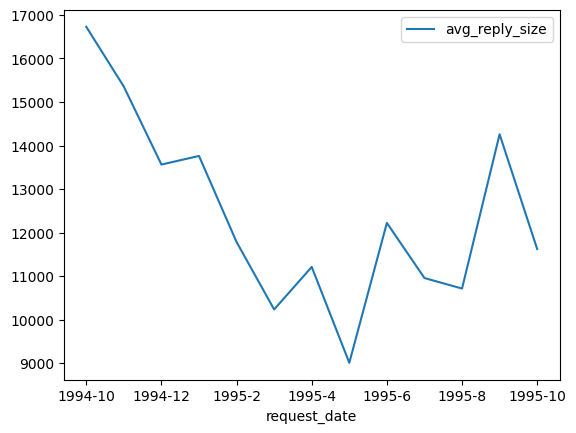

In [27]:
result = spark.sql("SELECT CONCAT(year(date), '-', month(date)) AS request_date, "
                   "AVG(reply_size) AS avg_reply_size, MAX(date) as sort_key "
                   "FROM logsView "
                   "WHERE reply_size IS NOT NULL "
                   "GROUP BY CONCAT(year(date), '-', month(date)) "
                   "ORDER BY sort_key").toPandas()
result.plot(x="request_date", y="avg_reply_size")

### HTTP methods distribution (log scale)

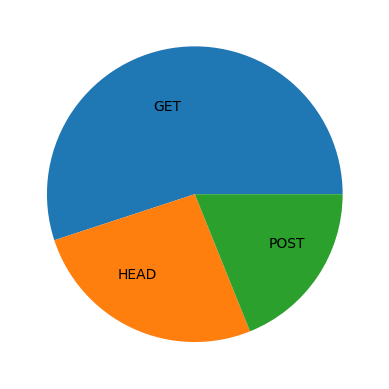

In [28]:
result = spark.sql("SELECT http_method, count(1) AS m_count "
                   "FROM logsView "
                   "WHERE http_method IS NOT NULL "
                   "GROUP BY http_method "
                   "ORDER BY m_count DESC").toPandas()
plt.figure()
plt.pie(result.m_count.apply(lambda x: np.log(x)), labels=result.http_method.tolist(), labeldistance=.6)
plt.show()

### Avg reply size by HTTP method

<Axes: xlabel='http_method'>

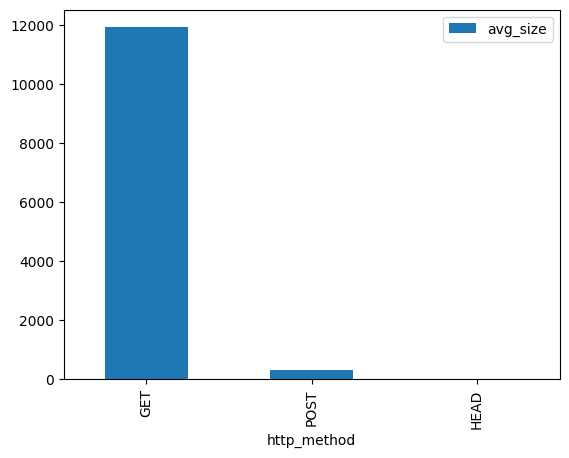

In [29]:
result = spark.sql("SELECT http_method, AVG(reply_size) AS avg_size "
                   "FROM logsView "
                   "WHERE http_method IS NOT NULL "
                   "GROUP BY http_method "
                   "ORDER BY avg_size DESC").toPandas()
result.plot(x="http_method", y="avg_size", kind="bar")

### Request count by weekday

<Axes: ylabel='day_of_week'>

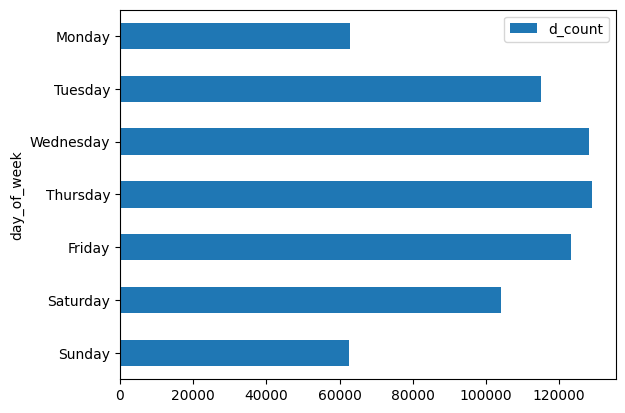

In [30]:
result = spark.sql("SELECT day_of_week, COUNT(1) AS d_count "
                   "FROM logsView "
                   "WHERE day_of_week IS NOT NULL "
                   "GROUP BY day_of_week "
                   "ORDER BY day_of_week DESC").toPandas()

result.day_of_week = result.day_of_week.map({1: "Monday", 2: "Tuesday", 3: "Wednesday", 
                                 4: "Thursday", 5: "Friday", 6: "Saturday", 7: "Sunday"})
result.plot(x="day_of_week", y="d_count", kind="barh")

In [31]:
spark.stop()